In [1]:
#노이즈 제거1: 문장부호 없애기 

def pad_punctuation(sentence, punc):
    for p in punc:
        sentence = sentence.replace(p, " " + p + " ") #p의 부호 앞뒤로 띄어써줌.

    return sentence

sentence = "Hi, my name is john."

print(pad_punctuation(sentence, [".", "?", "!", ","]))

Hi ,  my name is john . 


In [3]:
# 노이즈 제거2: 대문자 <-> 소문자 변환

sentence = "First, open the first chapter."

print(sentence.lower())

print(sentence.upper())

first, open the first chapter.
FIRST, OPEN THE FIRST CHAPTER.


In [4]:
#노이즈 제거3: 특수문자 치환

import re

sentence = "He is a ten-year-old boy."
sentence = re.sub("([^a-zA-Z.,?!])", " ", sentence) #특수문자를 공백으로 치환해주는 re.sub

print(sentence)

He is a ten year old boy.


## 분산표현과 희소표현

어느 표현이든 단어를 벡터로 표현하겠다는 점에서는 동일합니다. 하지만, 단어의 의미를 표현하는 접근 방식에서 큰 차이가 있습니다.

##### 희소표현
단어를 고차원 벡터로 변환하는 것이죠. 사람을 나이와 성별로 구분하기 위해선 적어도 2차원이 필요함

ex)  소년과 소녀입니다. 두 단어는 각각 어린 남자와 여자를 의미하니, 앞서 생성한 "성별" 이라는 속성에 "나이가 어리다" 라는 속성을 추가해야겠습니다. 즉, 소년: [-1, -1], 소녀: [1, -1] 이 되겠군요! "나이가 많다" 라는 속성을 가진 할아버지, 할머니는 자동적으로 할아버지: [-1, 1], 할머니: [1, 1] 이 되는 것도 알 수 있습니다.

그러나 이런 방식의 문제가 무엇일까요? 너무 고차원이 필요하고 불필요한 메모리와 연산량이 낭비된다는 점 말고도 중요한 문제점 하나는, 희소 표현의 워드 벡터끼리는 단어들 간의 의미적 유사도를 계산할 수 없다는 점입니다.



##### 분산표현

그래서 분산표현이라는 개념이 등장함. 우린 Embedding 레이어를 사용해 각 단어가 몇 차원의 속성을 가질지 정의하는 방식으로 단어의 분산 표현(distributed representation) 를 구현하는 방식을 주로 사용하게 됩니다. 만약 100개의 단어를 256차원의 속성으로 표현하고 싶다면 Embedding 레이어는 아래와 같이 정의되겠죠.

embedding_layer = tf.keras.layers.Embedding(input_dim=100, output_dim=256)

위 단어의 분산 표현에는 우리가 일일이 정의할 수 없는 어떤 추상적인 속성들이 256차원 안에 골고루 분산되어 표현됩니다. 희소 표현처럼 속성값을 임의로 지정해 주는 것이 아니라, 수많은 텍스트 데이터를 읽어가며 적합한 값을 찾아갈 것입니다. 적절히 훈련된 분산 표현 모델을 통해 우리는 단어 간의 의미 유사도를 계산하거나, 이를 feature로 삼아 복잡한 자연어처리 모델을 훈련시킬 수 있게 됩니다.

이에 대한 방법은 후술하도록 하죠!

In [7]:
#코사인 유사도 구하기 - 

#코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 
#두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 됩니다. 
#즉, 결국 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다.
#이를 직관적으로 이해하면 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다.


import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

print('문서 1과 문서2의 유사도 :',cos_sim(doc1, doc2))
print('문서 1과 문서3의 유사도 :',cos_sim(doc1, doc3))
print('문서 2와 문서3의 유사도 :',cos_sim(doc2, doc3))

#만약 의미속성을 공유하지 않는 두 희소표현의 코사인 유사도는 0입니다.

문서 1과 문서2의 유사도 : 0.6666666666666667
문서 1과 문서3의 유사도 : 0.6666666666666667
문서 2와 문서3의 유사도 : 1.0000000000000002


## 토큰화
문장을 단어 단위로 쪼개기 위해 정의하는 단계.


#### 토큰화가 필요한 이유?
자연어 처리 분야에서 매우 중요한 전처리 단계이며 문장을 작은 단위로 쪼개어 처리할 수 있도록 하는 과정입니다. 간단하게 텍스트 전처리, 문장의 의미 파악, 모델 성능 향상, 정보 검색 등을 하기 위해서 필요합니다. 토큰화는 자연어 처리에서 필수적인 단계이며, 적절한 토큰화 방법을 선택하여 자연어 처리 모델의 성능을 향상시킬 수 있습니다.


#### 공백기반 토큰화 (띄어쓰기 기반)
연어의 노이즈를 제거하는 방법 중 하나로 우리는 Hi, 를 Hi와 ,로 나누기 위해 문장부호 양옆에 공백을 추가해 주었습니다. 그것은 이 공백 기반 토큰화를 사용하기 위해서였죠! 당시의 예제 코드를 다시 가져와 공백을 기반으로 토큰화를 진행해 보겠습니다.

-> but, day와 days를 다르게 인식하는 등의 문제가 있음.


#### 형태소기반 토큰화
하지만 우리에겐 영어 문장이 아닌 한국어 문장을 처리할 일이 더 많을 것이고, 한국어 문장은 공백 기준으로 토큰화를 했다간 엉망진창의 단어들이 등장하는 것을 알 수 있습니다. 문장부호처럼 "은 / 는 / 이 / 가" 양옆에 공백을 붙이자구요? 글쎄요... 가로 시작하는 단어만 해도 가면, 가위, 가족, 가수... 의도치 않은 변형이 너무나도 많이 일어날 것 같네요!

이를 어떻게 해결할 수 있을까요? 정답은 형태소에 있습니다. 어릴 적 국어 시간에 배운 기억이 새록새록 나시나요? 상기시켜드리면 형태소의 정의는 아래와 같습니다.

(명사) 뜻을 가진 가장 작은 말의 단위.

예를 들어, 오늘도 공부만 한다 라는 문장이 있다면, 오늘, 도, 공부, 만, 한다 로 쪼개지는 것이 바로 형태소죠. 한국어는 이를 활용해 토큰화를 할 수 있습니다!

한국어 형태소 분석기는 대표적으로 KoNLPy가 사용됩니다.

https://konlpy-ko.readthedocs.io/ko/v0.4.3/  KONLPY 링크


#### Konlpy의 클래스5개

한나눔, 캄, 코모란, 메캡, 트위터(OKT)가 있으며, 각각 장단점이 있음. 속도랑 성능으로 비교해보자면,....

- 사용할 데이터의 특성(띄어쓰기 유무 등)이나 개발 환경(Python, Java)에 따라서 적합한 형태소 분석기를 고려해야함연산 속도가 중요하다면 mecab을 최우선으로 고려해야하며, 심지어 분석 품질도 상위권으로 보여짐
- 자소 분리나 오탈자에 대해서도 어느 정도 분석 품질이 보장되야 한다면 KOMORAN 사용을 고려
- 한나눔과 khaiii는 일부 케이스에 대한 분석 품질, 꼬꼬마는 분석 시간에서 약간 아쉬운 점이 보임

https://iostream.tistory.com/144


#### 형태소 분석기의 단점

모두 의미를 가지는 단위로 토큰을 생성합니다. 이 기법의 경우, 데이터에 포함되는 모든 단어를 처리할 수는 없기 때문에 자주 등장한 상위 N개의 단어만 사용하고 나머지는 <unk>같은 특수한 토큰(Unknown Token)으로 치환해버립니다. 
    
이를 OOV(Out-Of-Vocabulary) 문제라고 합니다. 이처럼 새로 등장한(본 적 없는) 단어에 대해 약한 모습을 보일 수밖에 없는 기법들이기에, 이를 해결하고자 하는 시도들이 있었습니다. 그리고 그것이 우리가 다음 스텝에서 배울, Wordpiece Model이죠!


In [8]:
# 공백기반 토큰화

corpus = \
"""
in the days that followed i learned to spell in this uncomprehending way a great many words ,  among them pin ,  hat ,  cup and a few verbs like sit ,  stand and walk .  
but my teacher had been with me several weeks before i understood that everything has a name . 
one day ,  we walked down the path to the well house ,  attracted by the fragrance of the honeysuckle with which it was covered .  
some one was drawing water and my teacher placed my hand under the spout .  
as the cool stream gushed over one hand she spelled into the other the word water ,  first slowly ,  then rapidly .  
i stood still ,  my whole attention fixed upon the motions of her fingers .  
suddenly i felt a misty consciousness as of something forgotten a thrill of returning thought  and somehow the mystery of language was revealed to me .  
i knew then that  w a t e r  meant the wonderful cool something that was flowing over my hand .  
that living word awakened my soul ,  gave it light ,  hope ,  joy ,  set it free !  
there were barriers still ,  it is true ,  but barriers that could in time be swept away . 
"""

tokens = corpus.split()

print("문장이 포함하는 Tokens:", tokens)

문장이 포함하는 Tokens: ['in', 'the', 'days', 'that', 'followed', 'i', 'learned', 'to', 'spell', 'in', 'this', 'uncomprehending', 'way', 'a', 'great', 'many', 'words', ',', 'among', 'them', 'pin', ',', 'hat', ',', 'cup', 'and', 'a', 'few', 'verbs', 'like', 'sit', ',', 'stand', 'and', 'walk', '.', 'but', 'my', 'teacher', 'had', 'been', 'with', 'me', 'several', 'weeks', 'before', 'i', 'understood', 'that', 'everything', 'has', 'a', 'name', '.', 'one', 'day', ',', 'we', 'walked', 'down', 'the', 'path', 'to', 'the', 'well', 'house', ',', 'attracted', 'by', 'the', 'fragrance', 'of', 'the', 'honeysuckle', 'with', 'which', 'it', 'was', 'covered', '.', 'some', 'one', 'was', 'drawing', 'water', 'and', 'my', 'teacher', 'placed', 'my', 'hand', 'under', 'the', 'spout', '.', 'as', 'the', 'cool', 'stream', 'gushed', 'over', 'one', 'hand', 'she', 'spelled', 'into', 'the', 'other', 'the', 'word', 'water', ',', 'first', 'slowly', ',', 'then', 'rapidly', '.', 'i', 'stood', 'still', ',', 'my', 'whole', 'attenti

In [9]:
# 형태소 분석기 사용(형태소기반 토큰화)

from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt


# import에러 발생시 커널에 다음과 같이 설치
# $ pip install konlpy
# $ cd ~/aiffel/text_preprocess
# $ git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# $ cd Mecab-ko-for-Google-Colab
# $ bash install_mecab-ko_on_colab190912.sh


# JVMNotFoundException 오류가 발생
# $ sudo apt update
# $ sudo apt install default-jre

# 형태소 분석기 실행

tokenizer_list = [Hannanum(),Kkma(),Komoran(),Mecab(),Okt()]

kor_text = '코로나바이러스는 2019년 12월 중국 우한에서 처음 발생한 뒤 전 세계로 확산된, 새로운 유형의 호흡기 감염 질환입니다.'

for tokenizer in tokenizer_list:
    print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.pos(kor_text)))

[Hannanum] 
[('코로나바이러스', 'N'), ('는', 'J'), ('2019년', 'N'), ('12월', 'N'), ('중국', 'N'), ('우한', 'N'), ('에서', 'J'), ('처음', 'M'), ('발생', 'N'), ('하', 'X'), ('ㄴ', 'E'), ('뒤', 'N'), ('전', 'N'), ('세계', 'N'), ('로', 'J'), ('확산', 'N'), ('되', 'X'), ('ㄴ', 'E'), (',', 'S'), ('새롭', 'P'), ('은', 'E'), ('유형', 'N'), ('의', 'J'), ('호흡기', 'N'), ('감염', 'N'), ('질환', 'N'), ('이', 'J'), ('ㅂ니다', 'E'), ('.', 'S')]
[Kkma] 
[('코로나', 'NNG'), ('바', 'NNG'), ('이러', 'MAG'), ('슬', 'VV'), ('는', 'ETD'), ('2019', 'NR'), ('년', 'NNM'), ('12', 'NR'), ('월', 'NNM'), ('중국', 'NNG'), ('우', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('에', 'VV'), ('서', 'ECD'), ('처음', 'NNG'), ('발생', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('뒤', 'NNG'), ('전', 'NNG'), ('세계', 'NNG'), ('로', 'JKM'), ('확산', 'NNG'), ('되', 'XSV'), ('ㄴ', 'ETD'), (',', 'SP'), ('새', 'NNG'), ('롭', 'XSA'), ('ㄴ', 'ETD'), ('유형', 'NNG'), ('의', 'JKG'), ('호흡기', 'NNG'), ('감염', 'NNG'), ('질환', 'NNG'), ('이', 'VCP'), ('ㅂ니다', 'EFN'), ('.', 'SF')]
[Komoran] 
[('코로나바이러스', 'NNP'), ('는', 'JX'), ('2019', 'SN'

### 다른 토큰화 방법: 워드피스 모델(WPM)

Wordpiece Model(WPM) 은 우리가 접한 적이 있는 아이디어를 기반으로 만들어졌습니다. 두 단어 preview와 predict를 보면 접두어인 pre가 공통되고 있죠? pre가 들어간 단어는 주로 "미리", "이전의" 와 연계되는 의미를 가지고 있습니다. 컴퓨터도 두 단어를 따로 볼 게 아니라 pre+view와 pre+dict로 본다면 학습을 더 잘 할 수 있지 않을까요?

이처럼 한 단어를 여러 개의 Subword의 집합으로 보는 방법이 WPM입니다. WPM의 원리를 알기 전, 먼저 알아야 할 것이 바로 Byte Pair Encoding(BPE) 입니다.


#### BPE란?

BPE 알고리즘이 고안된 것은 1994년입니다. 그때는 자연어 처리에 적용하기 위해서가 아니라 데이터 압축을 위해서 생겨났었죠. 데이터에서 가장 많이 등장하는 바이트 쌍(Byte Pair) 을 새로운 단어로 치환하여 압축하는 작업을 반복하는 방식으로 동작합니다.

따라서 BPE로 OOV문제를 해결할 수 있는데 원리는 다음과 같습니다.

OOV(Out-Of-Vocabulary) 문제는, 모델이 학습할 때는 본 적이 없는 단어나 문장이 테스트 데이터에 등장하여 발생하는 문제입니다.
이러한 단어나 문장은 모델이 인식하지 못하고, 예측 오류를 일으키게 됩니다.

BPE는 단어를 기본 단위인 문자(character) 단위로 분해한 후, 가장 자주 등장하는 문자의 쌍(pair)을 하나의 문자로 대체하는 방식으로 동작합니다. 이를 통해 기존에 없던 단어가 등장하더라도, 해당 단어를 구성하는 문자들의 조합이 기존에 등장했던 문자 쌍과 일치하는 경우,
기존에 등장했던 토큰들의 조합으로 변환하여 OOV 문제를 해결할 수 있습니다.

따라서, BPE는 OOV 문제를 해결하고, 텍스트 데이터를 더 효율적으로 인코딩하여 데이터의 압축을 향상시키는 효과를 가지고 있습니다.



논문 첨부: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1508.07909.pdf


In [ ]:
#BPE 코드

import re, collections

# 임의의 데이터에 포함된 단어들입니다.
# 우측의 정수는 임의의 데이터에 해당 단어가 포함된 빈도수입니다.
vocab = {
    'l o w '      : 5,
    'l o w e r '  : 2,
    'n e w e s t ': 6,
    'w i d e s t ': 3
}

num_merges = 5

def get_stats(vocab):
    """
    단어 사전을 불러와
    단어는 공백 단위로 쪼개어 문자 list를 만들고
    빈도수와 쌍을 이루게 합니다. (symbols)
    """
    pairs = collections.defaultdict(int) # collections.defaultdict 설명, https://excelsior-cjh.tistory.com/entry/collections-%EB%AA%A8%EB%93%88-defaultdict
    
    for word, freq in vocab.items():
        symbols = word.split()

        for i in range(len(symbols) - 1):             # 모든 symbols를 확인하여 
            pairs[symbols[i], symbols[i + 1]] += freq  # 문자 쌍의 빈도수를 저장합니다. 
        
    return pairs

def merge_vocab(pair, v_in):
    """
    문자 쌍(pair)과 단어 리스트(v_in)를 입력받아
    각각의 단어에서 등장하는 문자 쌍을 치환합니다.
    (하나의 글자처럼 취급)
    """
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
        
    return v_out, pair[0] + pair[1]

token_vocab = []

for i in range(num_merges):
    print(">> Step {0}".format(i + 1))
    
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get)  # 가장 많은 빈도수를 가진 문자 쌍을 반환합니다.
    vocab, merge_tok = merge_vocab(best, vocab)
    print("다음 문자 쌍을 치환:", merge_tok)
    print("변환된 Vocab:\n", vocab, "\n")
    
    token_vocab.append(merge_tok)
    
print("Merged Vocab:", token_vocab)

### WPM 코드

이에 구글에서 BPE를 변형해 제안한 알고리즘이 바로 WPM입니다. WPM은 BPE에 대해 두 가지 차별성을 가집니다.

공백 복원을 위해 단어의 시작 부분에 언더바 _ 를 추가합니다.
빈도수 기반이 아닌 가능도(Likelihood)를 증가시키는 방향으로 문자 쌍을 합칩니다. (더 '그럴듯한' 토큰을 만들어냅니다.)
첫 번째 문항은 아주 쉬운 내용으로, 앞서 사용한 예문을 빌리면 [_i, _am, _a, _b, o, y, _a, n, d, _you, _are, _a, _gir, l]로 토큰화를 한다는 것입니다. 이렇게 하면 문장을 복원하는 과정이 1) 모든 토큰을 합친 후, 2) 언더바 _를 공백으로 치환으로 마무리되어 간편하죠.

###  sonlpy

이외에도 한국어를 위한 토크나이저로 soynlp를 활용할 수 있습니다. soynlp는 한국어 자연어 처리를 위한 라이브러리인데요. 토크나이저 외에도 단어 추출, 품사 판별, 전처리 기능도 제공합니다.

https://github.com/lovit/soynlp


### 토큰에게 의미를 부여하기(유사도 연산을 위해서...)

각 토큰들이 랜덤하게 부여된 실수로 살아가지 않게, 그들끼리 유사도 연산을 할 수 있게 의미를 부여하는 알고리즘, 당연히 있습니다! 심지어 토큰화 기법보다 더 많이요! 대표적인 3가지만 알아보도록 하겠습니다. 이번 코스에선 간단하게 아이디어만 이해해도 충분합니다.


#### Word2Vec

Word2Vec은 "단어를 벡터로 만든다"는 멋진 이름을 가지고 있습니다. 난 오늘 술을 한 잔 마셨어 라는 문장의 각 단어 즉, 동시에 등장하는 단어끼리는 연관성이 있다는 아이디어로 시작된 알고리즘입니다. 예문의 경우 다른 단어는 몰라도 술과 마셨어는 괜찮은 연관성을 캐치해낼 수 있겠네요.

https://wikidocs.net/22660



##### CBOW

Word2Vec의 학습 방식에는 CBOW(Continuous Bag of Words)와 Skip-Gram 두 가지 방식이 있습니다. CBOW는 주변에 있는 단어들을 입력으로 중간에 있는 단어들을 예측하는 방법입니다. 반대로, Skip-Gram은 중간에 있는 단어들을 입력으로 주변 단어들을 예측하는 방법입니다. 메커니즘 자체는 거의 동일합니다. 먼저 CBOW에 대해서 알아보겠습니다. 이해를 위해 매우 간소화 된 예시로 설명합니다.

예문 : "The fat cat sat on the mat"

예를 들어서 갖고 있는 코퍼스에 위와 같은 예문이 있다고 합시다. ['The', 'fat', 'cat', 'on', 'the', 'mat']으로부터 sat을 예측하는 것은 CBOW가 하는 일입니다. 이때 예측해야하는 단어 sat을 중심 단어(center word)라고 하고, 예측에 사용되는 단어들을 주변 단어(context word)라고 합니다.

중심 단어를 예측하기 위해서 앞, 뒤로 몇 개의 단어를 볼지를 결정해야 하는데 이 범위를 윈도우(window)라고 합니다. 예를 들어 윈도우 크기가 2이고, 예측하고자 하는 중심 단어가 sat이라고 한다면 앞의 두 단어인 fat와 cat, 그리고 뒤의 두 단어인 on, the를 입력으로 사용합니다. 윈도우 크기가 n이라고 한다면, 실제 중심 단어를 예측하기 위해 참고하려고 하는 주변 단어의 개수는 2n입니다.

윈도우 크기가 정해지면 윈도우를 옆으로 움직여서 주변 단어와 중심 단어의 선택을 변경해가며 학습을 위한 데이터 셋을 만드는데 이 방법을 슬라이딩 윈도우(sliding window)라고 합니다.



##### Skip-gram

CBOW에서는 주변 단어를 통해 중심 단어를 예측했다면, Skip-gram은 중심 단어에서 주변 단어를 예측합니다. 앞서 언급한 예문에 대해서 동일하게 윈도우 크기가 2일 때, 데이터셋은 다음과 같이 구성됩니다


#### fast-text

### PART2. 멋진 단어 사전 만들기

#### 2-1 NLP EDA

In [1]:
#형태소분서기 import

from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [2]:
#라이브러리 import

import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [3]:
# 커널에 데이터 다운

# wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# mkdir -p ~/aiffel/sp_tokenizer/data
# mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
# cd ~/aiffel/sp_tokenizer/data
# tar -xzvf korean-english-park.train.tar.gz

In [5]:
#데이터 다운 및 확인

import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


다른 종류의 데이터는 하단의 링크에서 확인 가능

https://github.com/jungyeul/korean-parallel-corpora

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


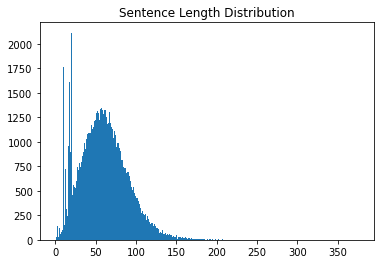

In [6]:
# 자연어 데이터 확인: 
# 아래 소스는 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해 주는 소스입니다. 
# raw 변수는 앞서 다운로드받은 데이터가 담긴 변수입니다!

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#### 데이터 시각화 뒤....   EDA  시작

최단 길이 1, 최장 길이 377... 그리고 제법 그럴듯한 막대그래프가 나왔습니다만, 이 결과를 확인하고 드는 생각은 아래와 크게 다르지 않으실 거예요..!

1) 길이 1 짜리 문장은 도대체 어떻게 생겨먹었지?

2) 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가?

3) 어디서부터 어디까지 잘라서 쓰지?

In [7]:
#길이가 1인 문장 확인

def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [8]:
# 별로 의미없는 문장을 걸러보자

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [9]:
# 길이가 11인 아웃라이어 문자 확인

check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

#### 중복제거를 위한 방법

이런... 심지어 중복에 대한 처리도 제대로 하지 않았었네요. 중복 제거는 Python의 기본 자료형 set을 활용할 겁니다. set은 집합을 정의하는 자료형인데, 중복을 허용하지 않아 변환 과정에서 자동으로 중복된 요소를 제거해 주거든요! 대신 list의 순서가 뒤죽박죽될 수 있으니, 만약 번역 데이터처럼 쌍을 이뤄야 하는 경우라면 주의해서 사용하셔야 합니다!

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


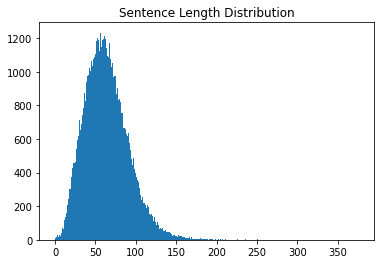

In [10]:
#중복제거 코드

min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### EDA 이어서...

이제서야 깔끔한 데이터를 얻은 느낌이 드네요. 데이터의 개수도 17000개 가량 줄어 77591개가 되었습니다.

마지막으로 '모든 데이터를 다 사용할 것이냐' 가 문제인데, 후에 미니 배치를 만들 것을 생각하면 모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적입니다. 미니 배치 특성상 각 데이터의 크기가 모두 동일해야 하기 때문에 가장 긴 데이터를 기준으로 Padding 처리를 해야 합니다. 위의 데이터에서 만약 길이가 100인 문장까지만 사용한다면 데이터는 [ (77591 - 길이 100 초과 문장 수) x 100 ] 의 형태를 갖겠지만 모두 사용할 경우 [ 77591 x 377 ] 로 전자보다 최소 3.7배 큰 메모리를 차지합니다. 학습 시간도 그만큼 더 오래 걸리고요.

길이별로 정렬하여 미니 배치를 구성해 Padding을 최소화하는 방법도 있지만 이는 데이터를 섞는 데 편향성이 생길 수 있으므로 지양해야 합니다. 여기서는 길이 150 이상의 데이터를 제거하고 사용하도록 할게요!

그리고 앞서 확인한 것처럼 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있습니다. 따라서 길이가 10 미만인 데이터도 제거하도록 하죠! 최종 데이터 분포도 함께 확인해봅시다.

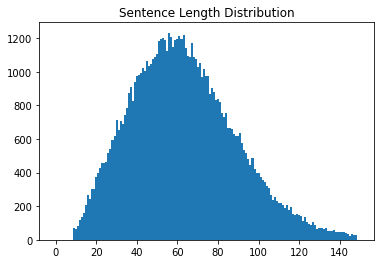

In [11]:
# 너무 길거나 짧은 데이터 Padding 처리

max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#### 2-2 공백기반 토큰화

배운 순서대로, 먼저 공백 기반 토큰화를 진행해 봅시다!

이전 스텝에서 얻은 정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 리스트 split_corpus에 저장한 후, 아래 tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻으세요! 그리고 단어 사전의 크기를 확인하세요!

In [13]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [14]:
#정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장하는 코드
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [15]:
# 토큰화 후 단어사전(코퍼스)의 길이 확인

split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [16]:
#토큰화된 단어 예시 10개까지 확인

for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


#### 공백기간 토큰화의 문제점

동사로 이루어진 단어를 살피면 공백 기반 토큰화의 문제점을 확인할 수 있습니다. 1번 단어인 밝혔다. 는 밝히다 , 밝다 등과 유사한 의미를 지니고 있음에도 전혀 다른 단어로 분류되겠죠? 이 때문에 공백 기반 토큰화는 불필요하게 큰 단어 사전을 가지게 되며 이는 연산량 증가로 이어집니다.

만일 밝 + 혔다 라고 토큰화했다면 어땠을까요? 밝 + 히다, 밝 + 다 같은 구절이 등장했을 때, 공통된 어절인 밝 은 하나로 묶여 학습 중에 의미를 파악하기가 수월해지겠죠? 동시에 단어 사전도 효율적으로 축소될 것입니다. 이를 위해 형태소 분석기가 존재합니다!

#### 2-3 형태소 기반 토큰화

한국어 형태소 분석기는 대표적으로 Khaiii와 KoNLPy가 사용됩니다. 이번 코스에서는 KoNLPy, 그중에서도 가장 성능이 준수한 MeCab클래스를 활용해 실습하도록 하겠습니다!

앞서 작성했던 코드를 활용해 MeCab 기반으로 생성된 단어 사전과 Tensor 데이터를 얻어 봅시다!

In [17]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [18]:
#형태소 기반 토큰화의 단어사전길이 확인

mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


#### 형태소 토큰화 평가

앞서 실습했던 공백 기반 단어 사전에 비해 단어 수가 현저히 줄어든 것을 확인하셨을 겁니다. 이는 곧 연산량의 감소로 이어져 더 빠른 학습을 가능케 하고, 심지어 모델이 튜닝해야 하는 매개변수(Parameter) 수가 줄어들어 학습도 더 잘 된답니다! 적어도 한국어를 처리할 때는 공백 기반 토큰화를 절대 지양하셔야 해요!

자주 사용되는 SentencePiece같은 Subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례들이 종종 있는데요, ETRI에서 발표한 한국어 BERT 모델인 KorBERT가 대표적인 사례 중 하나입니다. 아래 웹페이지를 방문하면 모델의 자세한 구조뿐 아니라 KorBERT 모델을 5가지 자연어 처리 태스크를 기준으로 평가했던 흥미로운 결과까지 살펴보실 수 있습니다!


#### Q. 구글의 Word Piece 기반 한국어 언어모델이 엑소브레인의 Word Piece 기반 한국어 언어모델보다 전체적으로 성능이 크게 떨어지는 것은 어떤 의미일까요? 여기서 유의해야 할 것은 언어모델(BERT)을 훈련시킨 원리는 동일하며, 토크나이저가 구성된 원리도 Word Piece 기반으로 동일하다는 점입니다.

구글에서 배포한 BERT 모델은 한국어 전용 코퍼스를 바탕으로 훈련된 것이 아니라 Multilingual 코퍼스를 바탕으로 훈련된 것이며, Word Piece 모델 안에 포함된 subword 안에도 한국어가 아닌 여러 언어의 것이 섞여 있어서 한국어 자연어처리 태스크에 특화된 모델이 아닙니다.

엑소브레인의 것은 한국어 코퍼스에 특화된 형태로 언어모델과 토크나이저가 훈련된 것이므로 엑소브레인과 구글의 BERT 모델의 한국어 테스크 성능 차이는 한국어에 특화된 언어 모델을 구축했을 때 기대할 수 있는 성능 향상치로 해석할 수 있습니다.

https://github.com/google-research/bert



#### Q. 엑소브레인의 BERT에 두 가지 버전이 있는데, 이 중 한국어 전용 형태소분석기 토크나이저를 사용한 버전이 WordPiece 모델 토크나이저를 사용한 버전보다 대체로 성능이 좋다는 것의 시사점은 무엇일까요?

WordPiece 모델은 해당 언어의 문법적 및 의미적 사전정보가 반영되지 않은 채 순수하게 통계적인 빈도 기반으로 자주 사용되는 반복 패턴을 사전으로 등재해 놓은 것에 불과합니다. 그에 비해 정확한 한국어 문법과 의미정보를 바탕으로 개발된 형태소분석기가 정확하게 동작한다면 현재까지 가장 성능이 좋다고 알려진 Subword 기반의 토크나이저보다 더 성능이 좋을 수 있음을 보여 줍니다.


#### Q. 정교한 형태소분석기를 활용한 모델의 성능이 더 좋을 수 있음에도 불구하고 현장에서 SentencePiece 같은 Subword 기반 토크나이저가 더욱 각광받는 이유는 무엇일까요?

언어는 지속적으로 변합니다. 정교한 형태소분석기의 성능을 유지하기 위해서는 지속적인 데이터관리와 유지보수 작업이 필요합니다.

그에 비해 SentencePiece 모델은 코퍼스데이터로부터 쉽게 추출해서 생성 가능하며, Subword 기반이기 때문에 새롭게 생성되는 단어에 대한 OOV(Out-of-Vocabulary) 문제에 대해서도 robust하게 대처할 수 있는 장점이 있습니다. 그리고 언어에 중립적이기 때문에 여러 언어가 섞여 나오는 텍스트를 처리하는 데에도 능합니다.

무엇보다도, 특정 언어에 대한 부가지식이 없이도 엔지니어가 그 언어에 대한 작업을 손쉽게 진행할 수 있도록 해준다는 점과 그 언어에 특화된 토크나이저의 성능에 뒤지지 않거나 대체로 능가하는 성능을 보여주기 때문입니다.


#### 임배딩 후 디코딩하는 과정

지금까지 문장을 Tensor로 Encoding하는 과정을 배웠는데요.
후에 모델이 생성한 Tensor를 문장으로 Decoding하는 과정도 필요하겠죠?

두 가지 방법으로 mecab_tensor[100] 을 원문으로 되돌려 보세요!
(여기서 띄어쓰기는 고려하지 않습니다!)

In [19]:
# Case 1 : tokenizer.sequences_to_texts()
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

지난주 경찰 은 14 세 의 중학생 을 성폭행 한 혐의 로 해병 을 체포 했으며 이 사건 은 일본인 들 의 분노 를 자아냈 다 .


In [20]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

지난주 경찰 은 14 세 의 중학생 을 성폭행 한 혐의 로 해병 을 체포 했으며 이 사건 은 일본인 들 의 분노 를 자아냈 다 . 
